In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5
import scienceplots

In [2]:
sys.path.append("../../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1, CNN_1D_Learned_Channel_Collapse

In [4]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
# load data from sin dataset
data_save_dir = Path("../../../data") / "gaussian_peak"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train_full = f["X"][:].squeeze(2)
    y_train_full = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test_full = f["X"][:].squeeze(2)
    y_test_full = f["y"][:]

print(f"X_train shape: {X_train_full.shape}")
print(f"y_train shape: {y_train_full.shape}")
print(f"X_test shape: {X_test_full.shape}")
print(f"y_test shape: {y_test_full.shape}")

X_train shape: (4000, 21)
y_train shape: (4000, 3)
X_test shape: (1000, 21)
y_test shape: (1000, 3)


In [6]:
n_train = 150
n_val = 250 # validation is much faster than training
n_test = 500 # testing is much faster than training
X_train = X_train_full[:n_train]
y_train = y_train_full[:n_train]
X_val = X_train_full[n_train:n_train+n_val]
y_val = y_train_full[n_train:n_train+n_val]
X_test = X_test_full[:n_test]
y_test = y_test_full[:n_test]

seq_len = X_train.shape[1]

# normalize data to [0, 1]
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_val = (X_val - X_val.min()) / (X_val.max() - X_val.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

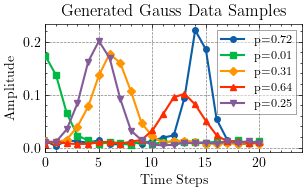

In [7]:
plt.style.use(["science", "grid"])
# plot some data
textwidth = 3.31314
aspect_ratio = 4/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
# plt.figure(figsize=(10, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['o', 's', 'D', '^', 'v']
for i in range(5):
    plt.plot(X_train[i], label=f"p={y_train[i][0]:.2f}", color=colors[i % len(colors)], marker=markers[i % len(markers)], markersize=4, linewidth=1.5, zorder=10)
    # plt.scatter(np.arange(seq_len), X_train[i], color=colors[i % len(colors)], s=10, zorder=5, marker=markers[i % len(markers)])
plt.title("Generated Gauss Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.xlim(0, seq_len + 3)
legend = plt.legend(fancybox=False, edgecolor="black", fontsize='small', framealpha=0.5)
legend.get_frame().set_linewidth(0.5)
# path = Path("figures")
# path.mkdir(parents=True, exist_ok=True)
# plt.savefig(path / "generated_gaussian_data_samples.pdf", bbox_inches='tight', dpi=300)
# print(f"Saved figure to {path / 'generated_gaussian_data_samples.pdf'}")
plt.show()


In [8]:
seq_len = X_train.shape[1]
hparams = {
    "kernel_size": (kernel_size := 4),  # =1D kernel size
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
    "dropout": 0.1,  # dropout bate
    "conv1_channels": 4,
}

CNN_classical = CNN_1D_Learned_Channel_Collapse(hparams=hparams)

In [9]:
# change model to float64
CNN_classical = CNN_classical.double()

# number of trainable parameters
n_params = sum(p.numel() for p in CNN_classical.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {n_params}")

Number of trainable parameters: 156


In [23]:
# train the model
batch_size = 16
epochs = 50
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
CNN_classical.train()
optimizer = torch.optim.Adam(
    CNN_classical.parameters(), lr=0.01, weight_decay=1e-5
)
params_hist = [copy.deepcopy(p) for p in CNN_classical.parameters()]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64).reshape(
            -1, 1, seq_len
        )
        y_batch = torch.tensor(
            y_train[i : i + batch_size, 0], dtype=torch.float64
        )
        batch_out = CNN_classical(x_batch)  # (batch_size, 1, seq_len)
        # predicted = torch.stack([bo["output"] for bo in batch_out])
        predicted = batch_out
        loss = loss_fn(predicted.squeeze(1), y_batch)
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append([copy.deepcopy(p) for p in CNN_classical.parameters()])
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss (MSE): {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.09629996094243572


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.09315076641228943


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.08385118224241442


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.06361732822467173


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.043366730899890495


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.02976312471347578


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.025023459702214645


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.022497712454542768


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.0231624007549537


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.021206602024841648


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.018874159626740158


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.01853504658965894


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.01352778157059443


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.013268853005962778


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.014411848025841442


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.012907592142671745


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.014032049411199279


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.0183691378430453


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.010174701618221593


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.016158326965724855


Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.008087652027314133


Epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.010815734165116305


Epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.011701582654367527


Epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.011727418372682815


Epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 train loss: 0.010122071110587934


Epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 train loss: 0.009389879890437072


Epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 train loss: 0.009495176788958264


Epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 train loss: 0.009878332494314138


Epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 train loss: 0.013734113247870753


Epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 train loss: 0.011542907339253549


Epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 train loss: 0.00723356525461772


Epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 train loss: 0.009293707976874802


Epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 train loss: 0.011064395681210776


Epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 train loss: 0.009602481927401332


Epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 train loss: 0.011846810256998888


Epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 train loss: 0.010476462336222995


Epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 train loss: 0.010417572016032129


Epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 train loss: 0.005127449203734173


Epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 train loss: 0.00950692138537019


Epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 train loss: 0.008826401401175254


Epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 train loss: 0.010235883090211922


Epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 train loss: 0.011790980942437796


Epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 train loss: 0.00921462342074817


Epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 train loss: 0.009716612523450059


Epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 train loss: 0.005458643343457484


Epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 train loss: 0.008063361270623874


Epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 train loss: 0.0033306048789907825


Epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 train loss: 0.00725898631729774


Epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 train loss: 0.0067822914480539665


Epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 train loss: 0.011019588361449652
Final loss (MSE): 0.003848812850152554
Final loss (RMSE): 0.062038801166306834


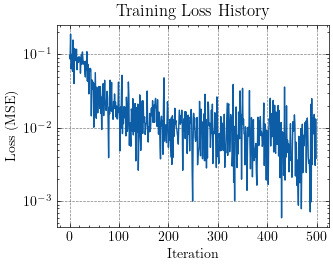

In [25]:
plt.plot(loss_hist)
plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.yscale("log")
plt.show()

In [26]:
# test the model
CNN_classical.eval()
y_pred_test = []
with torch.no_grad():
    x_test = torch.tensor(X_test, dtype=torch.float64).reshape(-1, 1, seq_len)  # (batch_size, 1, seq_len)
    y_test_tmp = torch.tensor(np.array(y_test[:,0]), dtype=torch.float64)
    predicted = CNN_classical(x_test).squeeze(1)  # (batch_size, 1, seq_len)
    y_pred_test.append(predicted.numpy())
    test_loss = loss_fn(predicted, y_test_tmp)
    print(f"Test loss (MSE): {test_loss.item()}")
    print(f"Test loss (RMSE): {np.sqrt(test_loss.item())}")
y_pred_test = np.concatenate(y_pred_test, axis=0)

Test loss (MSE): 0.004879594258209156
Test loss (RMSE): 0.0698540926375052


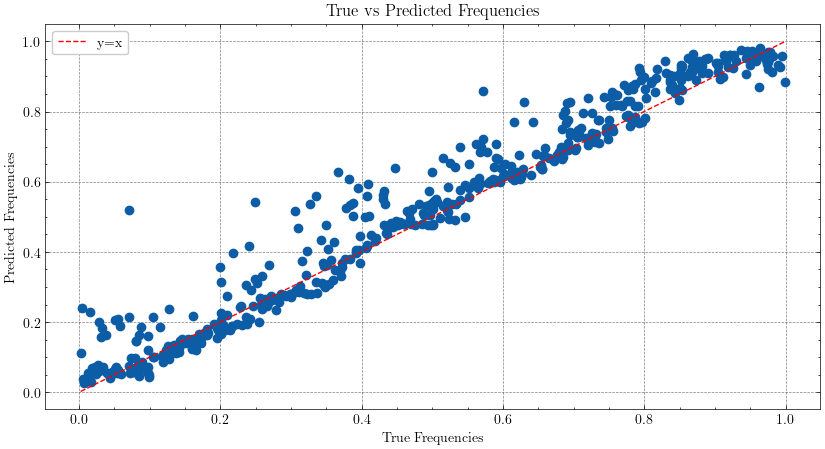

In [27]:
# plot the results
plt.figure(figsize=(10, 5))
plt.scatter(y_test_tmp, predicted.numpy())
# diagonal line
plt.plot([y_test_tmp.min(), y_test_tmp.max()], [y_test_tmp.min(), y_test_tmp.max()], 'r--', label='y=x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("True Frequencies")
plt.ylabel("Predicted Frequencies")
plt.legend()
plt.show()

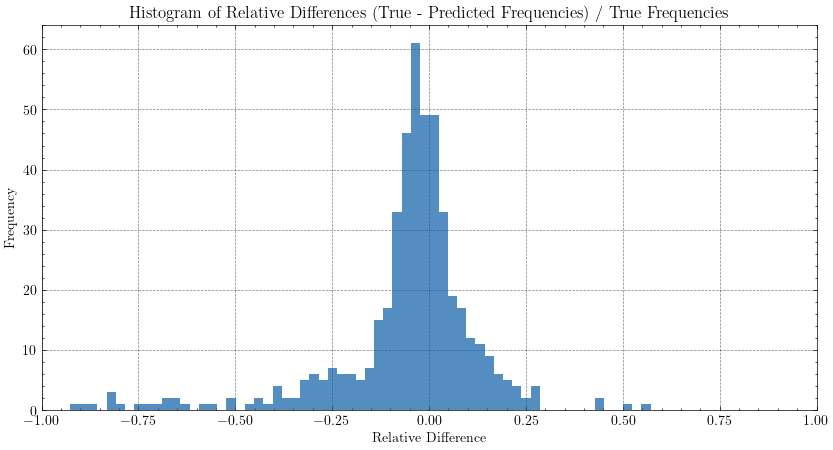

In [28]:
diffs = y_test[:,0] - y_pred_test
rel_diffs = diffs / y_test[:,0]  # relative differences
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(rel_diffs, bins=2000, alpha=0.7)
plt.title("Histogram of Relative Differences (True - Predicted Frequencies) / True Frequencies")
plt.xlabel("Relative Difference")
plt.ylabel("Frequency")
plt.xlim(-1, 1)  # limit x-axis to [-1, 1]
plt.show()

In [29]:
import pickle
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/classical_CNN_kernel_size_4_stride_3_gaussian_peak_train_hist_2025_07_28.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            test_loss.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

# Random Seed Sweep

In [35]:
# device = torch.device("cuda")
device = torch.device("cpu")
data = {
    "X_train": torch.tensor(X_train, dtype=torch.float64).to(device).reshape(-1, 1, seq_len),
    "y_train": torch.tensor(y_train[:,0:1], dtype=torch.float64).to(device),
    "X_val": torch.tensor(X_val, dtype=torch.float64).to(device).reshape(-1, 1, seq_len),
    "y_val": torch.tensor(y_val[:,0:1], dtype=torch.float64).to(device),
    "X_test": torch.tensor(X_test, dtype=torch.float64).to(device).reshape(-1, 1, seq_len),
    "y_test": torch.tensor(y_test[:,0:1], dtype=torch.float64).to(device),
}

In [46]:
def train_and_test_CNN_classical(epochs: int, data: dict, np_seed: int = 42, torch_seed = None, device = torch.device("cpu")):
    if torch_seed is None:
        torch_seed = np_seed
    np.random.seed(np_seed)
    torch.manual_seed(torch_seed)
    X_train = data["X_train"]
    y_train = data["y_train"]
    X_val = data["X_val"]
    y_val = data["y_val"]
    X_test = data["X_test"]
    y_test = data["y_test"]

    CNN_classical = CNN_1D_Learned_Channel_Collapse(hparams=hparams)
    CNN_classical = CNN_classical.double().to(device)  # move model to device

    # train the model
    loss_hist = []
    loss_hist_val = []
    loss_fn = torch.nn.MSELoss()
    CNN_classical.train()
    optimizer = torch.optim.Adam(
        CNN_classical.parameters(), lr=0.01, weight_decay=1e-5
    )
    for epoch in range(epochs):
        CNN_classical.train()
        # shuffle X_train and y_train
        idxs = np.arange(len(X_train))
        idxs = np.random.permutation(idxs)
        X_train = X_train[idxs]
        y_train = y_train[idxs]

        epoch_losses = []
        for i in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            x_batch = X_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size].to(torch.float64).squeeze(1)
            predicted = CNN_classical(x_batch)  # (batch_size, 1, seq_len)
            loss = loss_fn(predicted.squeeze(1), y_batch)
            epoch_losses.append(loss.item())
            loss_hist.append(loss.item())
            loss.backward()
            optimizer.step()
        epoch_loss = np.mean(epoch_losses)

        # validation
        CNN_classical.eval()
        with torch.no_grad():
            val_out = CNN_classical(X_val)
            val_loss = loss_fn(val_out.squeeze(1), y_val)
            loss_hist_val.append(val_loss.item())

    loss_hist = np.array(loss_hist)

    # testing
    CNN_classical.eval()
    with torch.no_grad():
        predicted = CNN_classical(X_test).squeeze(1)  # (batch_size, 1, seq_len)
        test_loss = loss_fn(predicted, y_test.squeeze(1))

    out = {
        "test_loss": test_loss.item(),
        "test_loss_rmse": np.sqrt(test_loss.item()),
        "train_history_rmse": np.sqrt(loss_hist),
        "val_history_rmse": np.sqrt(loss_hist_val),
        "hparams": hparams,
        "model_state_dict": CNN_classical.state_dict(),
    }

    return out

In [55]:
out_dicts = {}
n_tries = 5000
for np_seed in tqdm(range(n_tries)):
    out = train_and_test_CNN_classical(epochs=epochs, data=data, np_seed=np_seed, device=device)
    out_dicts[np_seed] = out
test_losses_rmse = [out["test_loss_rmse"] for out in out_dicts.values()]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/bigbogo/miniconda3/envs/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([250, 1])) that is different to the input size (torch.Size([250])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [56]:
losses_path = Path("losses_hist") / "sin" / "CNN_Classical_GaussPeak_RndSeedSweep.pickle"
losses_path.parent.mkdir(parents=True, exist_ok=True)
import pickle
with open(losses_path, "wb") as f:
    pickle.dump(out_dicts, f)

In [12]:
import pickle
losses_path = Path("losses_hist") / "sin" / "CNN_Classical_GaussPeak_RndSeedSweep.pickle"
with open(losses_path, "rb") as f:
    out_dicts = pickle.load(f)

Saved figure to figures/gauss/CNN_Classical_GaussPeak_RndSeedSweep.png


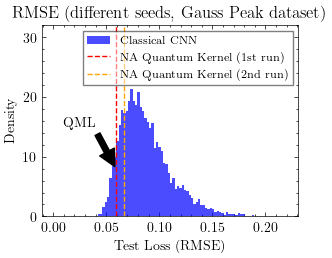

In [19]:
test_losses_rmse = [out["test_loss_rmse"] for out in out_dicts.values()]
# plot histogram of test losses
textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
plt.hist(test_losses_rmse, bins=100, density=True, alpha=0.7, color='blue', range=(0, 0.22), label='Classical CNN')
x_qml_1 = 0.0591
x_qml_2 = 0.0664
# vertical line and arrow at x_qml
plt.axvline(x=x_qml_1, color='red', linestyle='--', label='NA Quantum Kernel (1st run)')
plt.axvline(x=x_qml_2, color='orange', linestyle='--', label='NA Quantum Kernel (2nd run)')
plt.annotate('QML', xy=(x_qml_1, 8), xytext=(x_qml_1 - 0.05, 15),
             arrowprops=dict(facecolor='black', shrink=0.05))
legend = plt.legend(fancybox=False, edgecolor="black", fontsize='small', framealpha=0.5)
plt.title("RMSE (different seeds, Gauss Peak dataset)")
plt.xlabel("Test Loss (RMSE)")
plt.ylabel("Density")
plt.ylim(0, 32)
plt.grid()
plot_path = Path("figures") / "gauss" / "CNN_Classical_GaussPeak_RndSeedSweep.png"
plot_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(plot_path, bbox_inches='tight', dpi=300)
print(f"Saved figure to {plot_path}")
plt.show()

In [61]:
# Quantum model loss is better than % of classical cnn:
percentage_above_qml = np.mean(np.array(test_losses_rmse) > x_qml) * 100
print(f"Quantum model loss is better than {percentage_above_qml:.2f}% of classical CNN runs.")

Quantum model loss is better than 93.40% of classical CNN runs.
